# **1. Required libararies are imported**

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical, pad_sequences
from keras.callbacks import EarlyStopping
%matplotlib inline

# **2. Read dataset and pre processing**

In [4]:
df = pd.read_csv('/content/drive/MyDrive/spam.csv',delimiter=',',encoding='latin-1')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'],axis=1,inplace=True)


In [6]:
df.shape


(5572, 2)

Text(0.5, 1.0, 'Number of ham and spam messages')

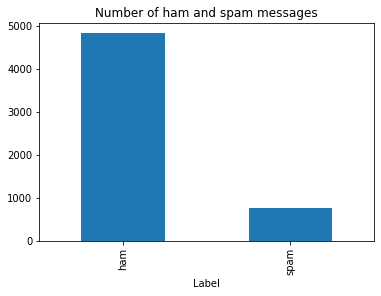

In [7]:
#plot the ham and spam messages to understand the distribution
df['v1'].value_counts().plot(kind='bar')
plt.xlabel('Label')
plt.title('Number of ham and spam messages')

In [8]:
X = df.v2
Y = df.v1
#label encoding for Y
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

# **3. Train-test split**

In [9]:
#split into train and test sets
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

# **4. Tokenizer**

In [10]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = keras.utils.pad_sequences(sequences,maxlen=max_len)

# **5. Add Layers(LSTM, Dense-(Hidden Layers), Output)**

In [11]:
inputs = Input(name='inputs',shape=[max_len])
layer = Embedding(max_words,50,input_length=max_len)(inputs)
layer = LSTM(64)(layer)
layer = Dense(256,name='FC1')(layer)
layer = Activation('relu')(layer)
layer = Dropout(0.5)(layer)
layer = Dense(1,name='out_layer')(layer)
layer = Activation('sigmoid')(layer)

# **6. Create Model**

In [12]:
model = Model(inputs=inputs,outputs=layer)


# **7. Compile the Model**


In [13]:
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 50)           50000     
                                                                 
 lstm (LSTM)                 (None, 64)                29440     
                                                                 
 FC1 (Dense)                 (None, 256)               16640     
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 out_layer (Dense)           (None, 1)                 257   

# **8.Fit the Model**


In [14]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])


Epoch 1/10
28/28 [==============================] - 10s 261ms/step - loss: 0.3243 - accuracy: 0.8822 - val_loss: 0.1654 - val_accuracy: 0.9552
Epoch 2/10
28/28 [==============================] - 9s 312ms/step - loss: 0.0844 - accuracy: 0.9815 - val_loss: 0.0938 - val_accuracy: 0.9742


# **9. Save the Model**


In [15]:
model.save('spam_lstm_model.h5')


# **10.Test the Model**


In [16]:
#processing test data
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = keras.utils.pad_sequences(test_sequences,maxlen=max_len)

In [17]:
#evaluation of our model
accr = model.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

35/35 [==============================] - 1s 22ms/step - loss: 0.1024 - accuracy: 0.9731
Test set
  Loss: 0.102
  Accuracy: 0.973
